In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy

from keras import initializers

from keras.layers import Activation


In [32]:
def custom_activation(x):
    
    return tf.math.erf(x/(tf.sqrt(2.*N)))

In [43]:
def custom_activation2(x):
    
    return np.sqrt(2/np.pi)*(x/np.sqrt(N))

def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return 1/2*tf.reduce_mean(squared_difference, axis=-1) 

In [44]:
def teacher_SCM(N,M,seed_M):
    tf.random.set_seed(91)
    teacher=tf.keras.models.Sequential([
                                  
    tf.keras.layers.Flatten(input_shape=(N,),name="layer0"),

    tf.keras.layers.Dense(M,activation=custom_activation,name="layer1",use_bias=False,kernel_initializer=initializers.orthogonal(gain=np.sqrt(N),seed=6))])

    out=tf.keras.layers.Dense(1, activation=None,name="layerout",use_bias=False,kernel_initializer=initializers.RandomNormal(stddev=0,mean=1/np.sqrt(M)))
    out.trainable=False
    teacher.add(out)
    teacher.compile(
        optimizer=tf.keras.optimizers.SGD(1),
        loss=my_loss_fn,
        metrics=None,
   
    )
        
    
    return teacher



def student_SCM(N,K,M,eta,seed_K):
    tf.random.set_seed(seed_K)
    np.random.seed(seed_K)
    input1 = tf.keras.Input(shape=(N,))
    input2 =tf.keras.Input(shape=(K,))
    input3 =tf.keras.Input(shape=(K,))
    input4 =tf.keras.Input(shape=(K,))
    hidden = tf.keras.layers.Dense(K, activation=custom_activation2,use_bias=False,
                               name="hidden",kernel_initializer=initializers.random_normal(stddev=0.,mean=0,seed=seed_K+3))(input1)
    
    mult= tf.keras.layers.multiply([hidden,input3])

    outputs = tf.keras.layers.Dense(1, activation=None,use_bias=False,trainable=False,
                                    name="out",kernel_initializer=initializers.random_normal(stddev=0.,mean=1/np.sqrt(K),seed=seed_K))(mult)
    student = tf.keras.Model(inputs=[input1,input3], outputs=outputs)
    student.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=eta),
        loss=my_loss_fn,
        metrics=None,
   
    )


    return student

In [45]:
def online_gen(student,teacher,N,p,seed):
    np.random.seed(97)
    values = np.random.normal(0,1,size=(N,K)).astype('float32')

    np.random.seed(None)
 
    for i in range(0,K):
        
    
        values[:,i]=values[:,i]/(np.linalg.norm(values[:,i]))*np.sqrt(N)
        
    b=[]
    b.append(values)
    b.append(student.weights[1].numpy())

    

    
    values=tf.convert_to_tensor(values)
    
    train=[]
    error_test=[]
    end=int(p/N)
    x_test=np.random.default_rng().standard_normal(size=(15000,N), dtype='float32')

    values_test=tf.transpose(tf.exp(-1/2*tf.transpose(tf.matmul(x_test,values)/np.sqrt(N))**2))
    for alpha in range(0,end):
        
        x_train=np.random.default_rng().standard_normal(size=(N,N), dtype='float32')
            
        values_train=tf.transpose(tf.exp(-1/2*tf.transpose(tf.matmul(x_train,values)/np.sqrt(N))**2))
        

        
        labels=teacher(x_train)
        
        labels_test=teacher(x_test)
        error_test.append(np.mean(teacher.loss(labels_test,student([x_test,values_test]))))
     
        history =student.fit(
           x=[x_train,values_train],
            y=labels,
            epochs = 1,
            batch_size=1,
            verbose = 0,
            use_multiprocessing=True)
       
        
        train.append(history.history["loss"])
        
        if not alpha%100:
            print(alpha)
            print(error_test[alpha])
        
    return np.array(error_test),np.array(train)

In [46]:
N=128
K=1024
M=1
end=1000
teacher=teacher_SCM(N,M,seed_M=2)
student=student_SCM(N,K,M,eta=0.1,seed_K=1)
np.random.seed(4)
values = np.random.normal(0,1,size=(N,K)).astype('float32')
    


In [47]:
h1024,b=online_gen(student,teacher,N,N*end,seed=4) 

0
0.16754924
100
0.00783985
200
0.0074322047
300
0.0074779904
400
0.007446899
500
0.0074221916
600
0.007462469
700
0.0074705253
800
0.007481448
900
0.007450837


In [51]:
t=np.linspace(1,len(h1024),len(h1024))

In [52]:
plateau=[]
for i in range(len(h1024)):
    plateau.append(1/6-1/(2*np.pi))

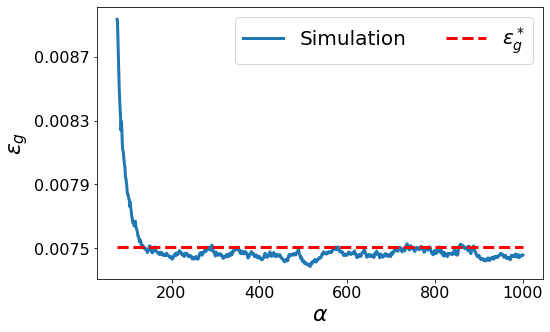

In [53]:
a=75
b=3500
plt.figure(figsize=(8,5))
plt.plot(t[a:b],h1024[a:b],linewidth=3)
plt.plot(t[a:b],plateau[a:b],linewidth=3,color="red",linestyle="--")
plt.xlabel(r"$\alpha$",size=22)
plt.ylabel(r"$\epsilon_g$",size=22)
plt.xticks(size=16)
plt.yticks([0.0075,0.0079,0.0083,0.0087],size=16)
plt.legend(["Simulation",r"$\epsilon_g^*$",r"$\frac{M}{N}=\frac{1}{8}$",r"$\frac{M}{N}=\frac{1}{16}$",r"$\frac{M}{N}=\frac{1}{32}$"],fontsize=20,ncol=2)
plt.show();
